## Climate Analysis and Exploration

In [1]:
#Import  Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, String, Float, ForeignKey,func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

In [2]:
#create engine and connections
engine = create_engine(os.path.join("sqlite:///","..","Resources","hawaii.db"),echo=False)
conn = engine.connect()

In [3]:
#create base class instance for reflecting the class
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)
# Print all of the classes mapped to the Base
Base.classes.keys()



['Measurements', 'Stations']

In [4]:
#set the classes to variables
measurements = Base.classes.Measurements
stations= Base.classes.Stations

In [5]:
#create session
session = Session(engine)

In [6]:
#display the table
first_row = session.query(measurements).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x278f0ff75f8>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65}

In [7]:
#display the table
first_row = session.query(stations).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x278f1005240>,
 'elevation': 3.0,
 'id': 1,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

### Precipitation Analysis

In [8]:
#select max date from measurements and extract month from it. subtract 1 from year. retreive value of that year
result = session.execute("SELECT max(date) FROM measurements order by date ").first()
new_d=result[0]
month=new_d.split("-")[1]
date=new_d.split("-")[2]
year=new_d.split("-")[0]
y=int(year)-1
new_date=str(y)+"-"+month+"-"+date
print(new_date)


2016-08-23


In [9]:
#create the query to retreive prcp for previous 12 months
precip_qry = session.query(stations.name,measurements.date, measurements.prcp).filter(measurements.date>=new_date).order_by(measurements.date)
print(precip_qry)

SELECT "Stations".name AS "Stations_name", "Measurements".date AS "Measurements_date", "Measurements".prcp AS "Measurements_prcp" 
FROM "Stations", "Measurements" 
WHERE "Measurements".date >= ? ORDER BY "Measurements".date


In [10]:
#create df from query and calculate the statistics
precip_df = pd.read_sql(precip_qry.statement, precip_qry.session.bind)
precip_df.describe()

,prcp
count,20070.000000
mean,0.175720
std,0.438975
min,0.000000
25%,0.000000
50%,0.030000
75%,0.160644
max,6.700000


In [11]:
#set the index of df as date
new_precip_df=precip_df.set_index("date")


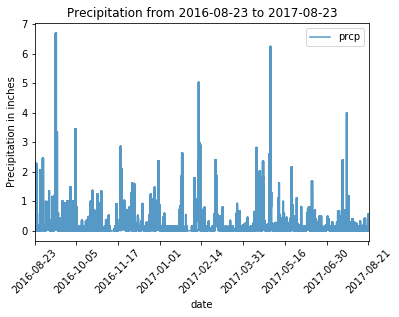

In [12]:
#plot thr graph
plt.figure(figsize=(20,10))
new_precip_df.plot(rot=45,alpha=0.75)
plt.ylabel('Precipitation in inches')
plt.xlabel("date")
plt.title("Precipitation from "+ str(new_precip_df.index.min())+ " to "+ str(new_precip_df.index.max()))
plt.savefig("../images/Precipitation from "+ str(new_precip_df.index.min())+ " to "+ str(new_precip_df.index.max()))
plt.show()



### Station Analysis


In [13]:
#calculate the stations
result = session.execute("SELECT  distinct station FROM measurements ").fetchall()
print("No .of Stations: " ,len(result))

No .of Stations:  9


In [14]:
#calculate the station with highest observations
result = session.execute("SELECT m.station, s.name, count(m.tobs) FROM measurements m inner join stations s where m.station=s.station group by s.station order by count(m.tobs) desc").first()
print("Station with Highest Observations is %s with %s observations " %(result[1],result[2]))

Station with Highest Observations is WAIHEE 837.5, HI US with 2772 observations 


In [15]:
#retrieve the data of station with highest observations
station_qry = session.query(measurements.tobs, measurements.station).filter(measurements.date>=new_date).filter(measurements.station==result[0]).order_by(measurements.date)
print(station_qry)

SELECT "Measurements".tobs AS "Measurements_tobs", "Measurements".station AS "Measurements_station" 
FROM "Measurements" 
WHERE "Measurements".date >= ? AND "Measurements".station = ? ORDER BY "Measurements".date


In [16]:
#save to df
\station_df = pd.read_sql(station_qry.statement, station_qry.session.bind)
station_df.head()

SyntaxError: unexpected character after line continuation character (<ipython-input-16-648632dd4be5>, line 2)

In [ ]:
#plot histogram
plt.hist(station_df["tobs"], normed=True, bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Observed Temperatures "+ str(new_precip_df.index.min()))
plt.savefig("../images/Observed Temperatures "+ str(new_precip_df.index.min()))
plt.show()

### Temperature Analysis

In [ ]:
#create a function for analysis temprature during travel 
def calc_temps(startdate_oftravel,enddate_oftravel):
    temp_qry = session.query(measurements.date, measurements.tobs).filter(measurements.date.between(startdate_oftravel,enddate_oftravel)).order_by(measurements.date)
    temp_df = pd.read_sql(temp_qry.statement, temp_qry.session.bind)
    max_temp=temp_df["tobs"].max()
    min_temp=temp_df["tobs"].min()
    avg_temp=temp_df["tobs"].mean()
    #return maximum minimum and avg temp during trip
    return min_temp,max_temp,avg_temp

In [ ]:
#inout start date and end date
start_date=input("Enter Start date of trip in %Y-%m-%d format")
end_date=input("Enter End  date of trip in %Y-%m-%d format")

temp=calc_temps(start_date,end_date)
#calculate temp for matching dates in previous year
prev_startdate=str(int(start_date.split("-")[0])-1)+"-"+start_date.split("-")[1]+"-"+start_date.split("-")[2]
prev_enddate=str(int(end_date.split("-")[0])-1)+"-"+end_date.split("-")[1]+"-"+end_date.split("-")[2]

prev_temp=calc_temps(prev_startdate,prev_enddate)

temp1=calc_temps('2016-05-01','2016-05-14')
print("==============================================================")
print("Temprature statistics from " + start_date +" to " + end_date)
print("Maximum Temprature: "+ str(temp[1]))
print("Minimum Temprature: "+ str(temp[0]))
print("Average Temprature: "+ str(temp[2]))
print("==============================================================")
print("Temprature statistics from " + prev_startdate +" to " + prev_enddate)
print("Maximum Temprature: "+ str(prev_temp[1]))
print("Minimum Temprature: "+ str(prev_temp[0]))
print("Average Temprature: "+ str(prev_temp[2]))


In [ ]:
#Plot the graph 
plt.figure(figsize=(1,4))
#set error value
err=temp[1]-temp[0]
x_axis = 0
plt.bar(x_axis, temp[2], yerr=err,color="r")
plt.xticks([0])
plt.ylabel("Temperature (F)")
plt.title("Trip Avg Temp from" + start_date + "to " + end_date)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
plt.savefig("../images/Trip Avg Temp from "+ start_date + "to " + end_date)
plt.show()

### Rainfall

In [ ]:
#calculate rainfall pre weather station
rain_qry = session.query(measurements.station, func.sum(measurements.prcp).label("rainfall")).\
                filter(measurements.date>=new_date).group_by(measurements.station)
rain_df = pd.read_sql(rain_qry.statement, rain_qry.session.bind)
rain_df

In [ ]:
#create function to calculate daily normals, that accept date in %m-%d format
def daily_normals(d):
    #extract tobs based on date
    norm_qry = session.query(measurements.station,measurements.tobs).\
                filter(measurements.date.like("%-" +d))
    #create df from query and calculate normal values
    
    df = pd.read_sql(norm_qry.statement, norm_qry.session.bind)
    max_temp=df["tobs"].max()
    min_temp=df["tobs"].min()
    avg_temp=df["tobs"].mean()
    
    #return maximum minimum and avg temp during trip
    return min_temp,max_temp,avg_temp

In [ ]:
#enter start and dend date for the trip
start_date=input("Enter Start date of trip in %Y-%m-%d format")
end_date=input("Enter End  date of trip in %Y-%m-%d format")
#create the trip dates using date_range()
d=pd.date_range(start_date,end_date)
#convert to %m-%d format
d=d.strftime('%m-%d')

In [ ]:
#for each date create a list of normal values
norm_list=[]
for each in d:
    norm=daily_normals(str(each))
    norm_list.append([each,norm[1],norm[0],norm[2]])

labels=["Date","Maximum Temp","Min Temp","Avg Temp"]
norm_df=pd.DataFrame(norm_list,columns=labels)
norm_df=norm_df.set_index("Date")
norm_df

In [ ]:
norm_df.plot.area(stacked=False)
plt.title("Daily normals from "+ start_date + "to " + end_date)
plt.savefig("../images/Daily normals from "+ start_date + "to " + end_date)
plt.show()